# DESI Iron
Determine how many galaxies were observed in DESI Iron that are good TF targets by finding the number of unique galaxies observed with observations at the center and at .4R.

In [1]:
## Module imports and constant definitions 
from astropy.table import unique, Table
from astropy.coordinates import SkyCoord
from astropy.io import fits 

import astropy.units as u

import numpy as np

# import matplotlib as mpl
# import matplotlib.pyplot as plt
import ligo.skymap.plot
from matplotlib import pyplot as plt

from tqdm.auto import tqdm

import os

import requests

from astropy.wcs import WCS
from astropy.visualization.wcsaxes import SphericalCircle

In [2]:
h = 1
H0 = 100*h

c = 3e5

q0 = 0.2

V0 = 2.5 # 0-point of TFR

### Iron Data
We read in the Iron data to use throughout the notebook. Commented out below is the Fuji data, to use to check against when necessary. 

In [3]:
tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_iron_healpix.fits')
#tiron = Table.read('/global/cfs/projectdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

tiron[:5]

TARGETID,TARGET_RA,TARGET_DEC,HEALPIX,SURVEY,Z,ZERR,ZWARN,DELTACHI2,FILENAME,PVTYPE,SGA_ID,RA,DEC
int64,float64,float64,int64,bytes4,float64,float64,int64,float64,bytes65,bytes3,int64,float64,float64
2852147603439621,198.369130660983,36.5372037049171,10475,main,0.815976335547845,7.38513168100107e-05,4,0.128754377365112,iron/healpix/main/dark/104/10475/redrock-main-dark-10475.fits,EXT,649377,198.36913066098333,36.537203704917076
2399148812795907,198.371733180003,36.4994335406917,10475,main,1.11088784970434,7.48767797671894e-05,4,7.9473560154438,iron/healpix/main/bright/104/10475/redrock-main-bright-10475.fits,EXT,649377,198.37173318000336,36.499433540691676
2399382443917318,184.845242475328,49.8157304793777,10995,main,1.14739342108157,0.000146302276719084,4,2.56771463155746,iron/healpix/main/bright/109/10995/redrock-main-bright-10995.fits,EXT,1008911,184.84524247532795,49.81573047937771
2399634072797192,184.341289722203,70.8283725474297,11965,main,1.51703376230705,6.28979649962091e-05,4,4.76254060305655,iron/healpix/main/bright/119/11965/redrock-main-bright-11965.fits,EXT,241234,184.34128972220284,70.82837254742968
2852141710442505,123.256011148025,36.2652948002806,6448,main,0.00787379494184006,3.4714052819995e-05,0,22.1719104201402,iron/healpix/main/dark/64/6448/redrock-main-dark-6448.fits,EXT,31591,123.25601114802525,36.26529480028061


### SGA
We read in the SGA to use throughout the notebook. 

In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

## Create a dictionary of SGA IDs to find row indices 
SGA_dict = {}
for i in range(len(SGA)):
    SGA_dict[SGA['SGA_ID'][i]] = i

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## Separation between Galaxies and Observations
Find all targets on each galaxy, and then calculate distance between SGA center coordinates and observation coordinates. Store the lists of center and axis observations as `iron_centers` and `iron_axis`.

In [5]:
tiron['SKY_FIBER_DIST'] = 0.
tiron['SKY_FIBER_DIST_R26'] = 0.

## For each SGA galaxy that has 1+ observations, calculate distance for all of its targets
for sga_id in tqdm(np.unique(tiron['SGA_ID'])):
    
    ## Identify all galaxy targets on this galaxy
    obs_idx = tiron['SGA_ID'] == sga_id
    
    ## Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    ## Calculate distance between each observation and the center of the galaxy
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tiron['RA'][obs_idx], 
                             dec=tiron['DEC'][obs_idx], 
                             unit=u.degree)
    sep2d = target_coords.separation(SGA_coords)
    
    ## Add the distance to the tiron table
    tiron['SKY_FIBER_DIST'][obs_idx] = sep2d
    
    ## Add the distance in R26 to the tiron table 
    tiron['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)

  0%|          | 0/75152 [00:00<?, ?it/s]

In [6]:
## Isolate the centers to be those measurements where the distance is <.1*R26
centers_boolean = tiron['SKY_FIBER_DIST_R26'] < 0.1

## Sort observations into center and axis observations 
iron_centers = tiron[centers_boolean]
iron_axis = tiron[~centers_boolean]

## Cleaning Iron Center Observations

Only keep observations with
 * `DELTACHI2` > 25
 * `ZWARN` == 0

In [7]:
good_centers = iron_centers[(iron_centers['DELTACHI2'] > 25) & (iron_centers['ZWARN'] == 0)]

## Check for multiple good center observations 
unique_ids, counts = np.unique(good_centers['SGA_ID'], return_counts=True)

If there is at least one good center observation, set the galaxy's redshift as the weighted average of all observation redshifts.

In [8]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in tqdm(np.unique(good_centers['SGA_ID'])):
    
    ## Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    ## Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be weighted average of all good center observation redshifts
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

  0%|          | 0/70100 [00:00<?, ?it/s]

Determine how many observations we have at $0.4R_{26}$ that have a corresponding center observation for that galaxy.

In [9]:
## Include all observations where .38R < distance < .42R in our .4R values
r0p4 = iron_axis[(iron_axis['SKY_FIBER_DIST_R26'] > 0.38) & (iron_axis['SKY_FIBER_DIST_R26'] < 0.42)]

## Count how many of these are unique values
unique_centers = np.unique(good_centers['SGA_ID'])
unique_r0p4 = np.unique(r0p4['SGA_ID'])

centers_and_p4s = []
for i in unique_r0p4: 
    if i in unique_centers: 
        centers_and_p4s.append(i)

## Output the number of observations that are generally good for TF fitting
print(len(centers_and_p4s), "unique galaxies with center and 0.4R observations")

## Find the percentage of all Iron galaxies that are generally good for TF fitting
num_iron = len(np.unique(tiron['SGA_ID']))
percentage_TF = 100*((len(centers_and_p4s))/num_iron)
print(f"{percentage_TF:.1f}% of all Iron galaxies")

11819 unique galaxies with center and 0.4R observations
15.7% of all Iron galaxies


## Cluster Membership
Following Cosmicflows4 (Kourkchi et al. 2020), cluster membership is defined as
- $R_p < 1.5R_{2t}$ and $v < V_c \pm 3\sigma_p$
- $1.5R_{2t} \leq R_p < 3R_{2t}$ and $v < V_c \pm 2\sigma_p$

where $R_p$ is the projected distance from the cluster center, $R_{2t}$ is the cluster projected second turnaround radius, $\sigma_p$ is the projected velocity dispersion of the cluster, and $V_c$ is the average heliocentric radial velocity of the cluster.

### Tully et al. (2015) Table 3

In [10]:
hdu = fits.open("../Tully15-Table3.fits")
table3 = Table(hdu[1].data)
table3.rename_column("<Vcmba>","VMod")
hdu.close()

table3_dict = {}
for i in range(len(table3)):
    table3_dict[table3['Nest'][i]] = i

table3[:5]

f_Nest,Nest,Nmb,PGC1,SGLON,SGLAT,logLK,VMod,DM,sigV,R2t,sigP,Mlum,CF
int16,int32,int16,int32,float64,float64,float64,int32,float64,int16,float64,int16,float64,float64
1,100001,136,44715,89.6226,8.1461,13.15,7331,34.33,886,2.129,1045,1710000000000000.0,1.65
1,100002,197,41220,103.0008,-2.3248,12.69,1491,30.87,670,1.44,707,529000000000000.0,1.0
1,100003,113,43296,156.2336,-11.5868,12.75,3873,32.94,822,1.52,746,623000000000000.0,1.12
1,100004,81,58265,71.5103,49.7851,13.16,9424,34.87,740,2.153,1057,1770000000000000.0,2.26
1,100005,61,36487,92.0255,-10.495,12.78,6987,34.22,707,1.56,766,673000000000000.0,1.58


### Tully et. al (2013) Table 2

In [11]:
hdu = fits.open("../Tully13-Table2.fit")
table2 = Table(hdu[1].data)
hdu.close()

table2[:5]

_RAJ2000,_DEJ2000,N1,__Dist_,__DM_,__Err_,N2,GLON,GLAT,SGLON,SGLAT,GMT,__Bmag_,__Kmag_,__HV_,__GV_,__Vls_,__Vcmb_,__Vcmba_,sigma,__PV_,__PVa_,Group,Ng,_2M__,PGCb,GName,_2M,Simbad,NED,recno
float64,float64,int16,float64,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,int32,int32,int32,int32,int32,int16,int32,int32,int16,int16,int16,int32,str10,str2,str6,str3,int32
266.404996,-28.936172,16,0.01,14.5,0.02,20,0.0,0.0,185.7861,42.3103,1,-6.0,-9.0,51,26,13,91,91,64,90,90,223,16,0,17223,Galaxy,2M,Simbad,NED,1
15.693346,36.392682,39,0.76,24.4,0.01,41,125.479,-26.423,322.2989,9.4579,2,3.4,0.68,-213,-49,17,-485,-484,156,-541,-547,222,39,0,2557,NGC0224,2M,Simbad,NED,2
149.896678,-12.831016,4,1.37,25.68,0.03,4,251.1365,32.2601,120.502,-42.5472,10,9.75,9.29,347,153,103,690,691,23,589,589,227,4,0,29128,NGC003109,2M,Simbad,NED,3
139.011477,52.840941,1,1.37,25.68,0.1,1,164.6636,42.8855,47.6118,-15.0125,10,13.75,11.5,-29,17,45,130,130,0,28,28,0,579,0,26142,UGC4879,2M,Simbad,NED,4
243.448636,54.37081,1,1.91,26.41,0.08,1,83.8788,44.4092,56.0935,40.37,10,16.69,12.9,-139,44,78,-121,-120,0,-262,-268,230,1,0,2801026,KKR25,2M,Simbad,NED,5


Loop through the SGA table and collect just the rows with `SGA_ID` values that are included in `centers_and_p4s` in a new table.

In [12]:
SGA.add_index("SGA_ID")
TF_SGA_cp4 = SGA.loc[centers_and_p4s]

TF_SGA_cp4[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005,0.025270721,0.034526117,0.039107796,0.024264116,0.033164512,0.03780495,0.02343744,0.03226152,0.037176747,0.022813411,0.031564914,0.036686495,0.022342678,0.031088097,0.03649375,17.87426,0.7614885,0.3679447,2.3644495,0.004768816,17.421976,0.45777154,0.33258685,2.8184628,0.021122098,17.150808,0.27153513,0.24329957,3.8143618,0.0151183605,0,0.0809898865247745,3.77329579263809e-06
55,SGA-2020 55,PGC1203947,1203947,199.73061299999998,1.7263548999999998,S?,159.49,0.35156044,0.510505,0.04396308,24.6

## Determine Iron Cluster Membership
This cell loops through all Nest numbers given in Tully 2015 Table 3, determines the coordinates, and matches galaxies to their nearest cluster. It collects the center and axis observations for each cluster, and stores the Nest number in `full_clusters` along with a table of center and axis observations in `c_4r_in_cluster`. 

At present, this cell is returning some suspicious values.

In [13]:
full_cluster = []
v_cluster = []
c_4r_in_cluster = []

# Define group coordinates object (used to find heliocentric velocity for each cluster)
group_coords = SkyCoord(table2['SGLON']*u.degree, 
                        table2['SGLAT']*u.degree, 
                        frame='supergalactic')

# Define SGA galaxy coordinates object
SGA_coords = SkyCoord(TF_SGA_cp4['RA'], TF_SGA_cp4['DEC'], unit='deg')

for nest_id in tqdm(table3["Nest"][:100]):
    
    ## Set active row for each nest number and base values 
    i_cluster = table3_dict[nest_id]
    
    R2t = table3["R2t"][i_cluster]
    sigma = table3["sigP"][i_cluster]
    
    ## Find the coordinates for each cluster
    cluster_coords = SkyCoord(table3["SGLON"][i_cluster]*u.degree, 
                              table3["SGLAT"][i_cluster]*u.degree, 
                              frame='supergalactic')
    
    # print(cluster_coords, cluster_coords.transform_to('icrs'))
    
    ## Match cluster to group coordinates 
    idx, d2d, d3d = cluster_coords.match_to_catalog_sky(group_coords)
    v = table2["__HV_"][idx]
    
    ## Match SGA coordinates from unique galaxies to nearest cluster
    sep = cluster_coords.separation(SGA_coords)

    ## Convert R2t to an angle 
    R2t_angle = (R2t/(v/H0))*u.radian
    
    SGA_in_cluster1 = (sep < 1.5*R2t_angle) & (TF_SGA_cp4["Z_DESI"]*c > v - 3*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 3*sigma)
    SGA_in_cluster2 = (sep >= 1.5*R2t_angle) & (sep < 3*R2t_angle) & (TF_SGA_cp4["Z_DESI"]*c > v - 2*sigma) & (TF_SGA_cp4["Z_DESI"]*c < v + 2*sigma)
    
    SGA_in_cluster = SGA_in_cluster1 | SGA_in_cluster2
    
    ## Keep observations that are within nest cluster 
    SGA_ID_in_cluster = TF_SGA_cp4["SGA_ID"][SGA_in_cluster]
    
    ## Gather centers and axes in the cluster
    centers_in_cluster = good_centers[np.in1d(good_centers['SGA_ID'], SGA_ID_in_cluster)]
    axis_in_cluster = iron_axis[np.in1d(iron_axis['SGA_ID'], SGA_ID_in_cluster)]
    
    if len(SGA_ID_in_cluster) > 20:
        print("CLUSTER ID:", nest_id, "--", len(SGA_ID_in_cluster), "GALAXIES"),
        full_cluster.append(nest_id)
        v_cluster.append(v)
        c_4r_in_cluster.append(SGA_ID_in_cluster)

  0%|          | 0/100 [00:00<?, ?it/s]

CLUSTER ID: 100002 -- 131 GALAXIES
CLUSTER ID: 100007 -- 27 GALAXIES
CLUSTER ID: 100015 -- 54 GALAXIES
CLUSTER ID: 100042 -- 72 GALAXIES
CLUSTER ID: 100046 -- 23 GALAXIES
CLUSTER ID: 100051 -- 21 GALAXIES
CLUSTER ID: 100058 -- 37 GALAXIES
CLUSTER ID: 100071 -- 45 GALAXIES
CLUSTER ID: 100073 -- 26 GALAXIES
CLUSTER ID: 100077 -- 152 GALAXIES
CLUSTER ID: 100078 -- 23 GALAXIES
CLUSTER ID: 100081 -- 25 GALAXIES
CLUSTER ID: 100094 -- 27 GALAXIES


In [14]:
print(len(np.unique(np.concatenate(c_4r_in_cluster))), len(np.concatenate(c_4r_in_cluster)))

519 663


In [15]:
cluster_coords = SkyCoord(table3['SGLON']*u.degree, 
                          table3['SGLAT']*u.degree, 
                          frame='supergalactic')

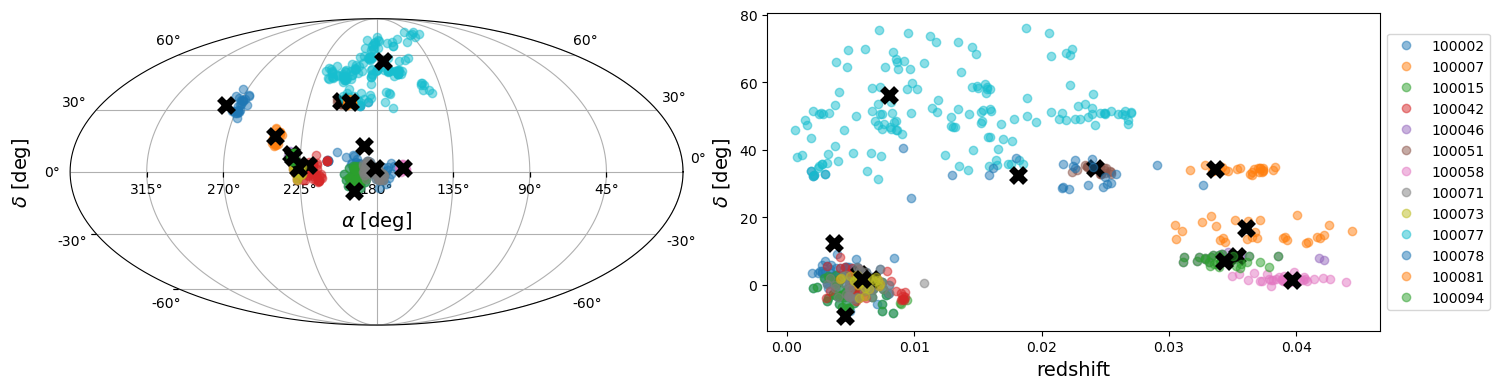

In [85]:
fig = plt.figure(figsize=(15,4), tight_layout=True)

# colors = ['tab:blue', 'tab:orange', 'tab:green']

ax_sky = plt.subplot(121, projection='astro degrees mollweide')#, center="180d 0d", radius='90 deg')
ax_sky.grid()
for i in range(len(full_cluster)):
    
    table3_i = table3_dict[full_cluster[i]]
    
    ax_sky.plot(TF_SGA_cp4.loc[c_4r_in_cluster[i]]['RA'], 
                TF_SGA_cp4.loc[c_4r_in_cluster[i]]['DEC'], 
                'o', 
                transform=ax_sky.get_transform('world'),
                alpha=0.5, label=str(full_cluster[i]))
    ax_sky.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
                cluster_coords[table3_i].transform_to('icrs').dec.deg, 
                'kx', 
                transform=ax_sky.get_transform('world'),
                ms=10, mew=5)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)

ax = plt.subplot(122)
for i in range(len(full_cluster)):
    
    table3_i = table3_dict[full_cluster[i]]
    
    ax.plot(TF_SGA_cp4.loc[c_4r_in_cluster[i]]['Z_DESI'], 
             TF_SGA_cp4.loc[c_4r_in_cluster[i]]['DEC'], 
             'o', alpha=0.5, label=str(full_cluster[i]))
    
    ax.plot(v_cluster[i]/c, 
             cluster_coords[table3_i].transform_to('icrs').dec.deg, 
             'kx', ms=10, mew=5)

# plt.xlim((0.0125, 0.035))
ax.set_xlabel('redshift', fontsize=14)
ax.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));

<SkyCoord (ICRS): (ra, dec) in deg
    (187.76381061, 12.28264393)>
1104
22.29422391351752 deg


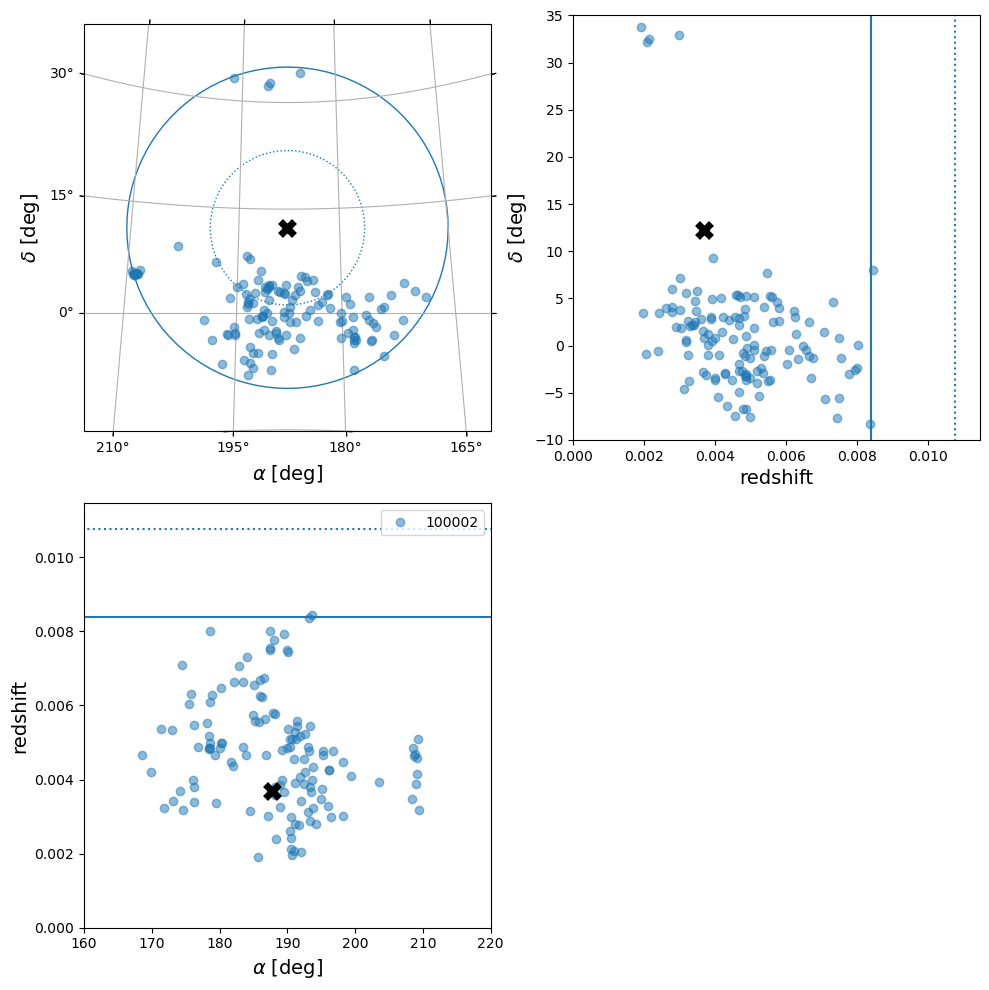

In [52]:
cluster = 100002

table3_i = table3_dict[cluster]
i = np.array(full_cluster) == cluster

cluster_center = cluster_coords[table3_i].transform_to('icrs')
print(cluster_center)

cluster_v = np.array(v_cluster)[i][0]
print(cluster_v)

cluster_sigma = table3['sigP'][table3_i]

cluster_R2t = np.arctan(table3['R2t'][table3_i]/(cluster_v/H0))*u.radian
print(3*cluster_R2t.to('degree'))



plt.figure(figsize=(10,10), tight_layout=True)

ax_sky = plt.subplot(221, projection='astro degrees zoom', center=cluster_center, radius=4*cluster_R2t)
ax_sky.grid()
    
ax_sky.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
            TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
            'o', 
            transform=ax_sky.get_transform('world'), 
            alpha=0.5, label=str(cluster))
ax_sky.plot(cluster_center.ra.deg, 
            cluster_center.dec.deg, 
            'kx', 
            transform=ax_sky.get_transform('world'), 
            ms=10, mew=5)

# 1.5 R2t
inner_limit = SphericalCircle(cluster_center, 1.5*cluster_R2t, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='dotted', facecolor='none')
ax_sky.add_patch(inner_limit)

# 3 R2t
outer_limit = SphericalCircle(cluster_center, 3*cluster_R2t, transform=ax_sky.get_transform('world'), edgecolor='tab:blue', linestyle='solid', facecolor='none')
ax_sky.add_patch(outer_limit)

ax_sky.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax_sky.set_ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(222)
    
plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         'o', alpha=0.5, label=str(cluster))
    
plt.plot(cluster_v/c, 
         cluster_coords[table3_i].transform_to('icrs').dec.deg, 
         'kx', ms=10, mew=5)

# velocity limits
plt.vlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
            cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           -30, 90, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

plt.xlim(xmin=0)
plt.ylim((-10, 35))

plt.xlabel('redshift', fontsize=14)
plt.ylabel(r'$\delta$ [deg]', fontsize=14)
# plt.tick_params(axis='both', which='major', labelsize=12)




plt.subplot(223)

plt.plot(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         'o', alpha=0.5, label=str(cluster))

plt.plot(cluster_coords[table3_i].transform_to('icrs').ra.deg, 
         cluster_v/c, 
         'kx', ms=10, mew=5)

# velocity limits
plt.hlines(np.array([cluster_v - 3*cluster_sigma, cluster_v + 3*cluster_sigma, 
                     cluster_v - 2*cluster_sigma, cluster_v + 2*cluster_sigma])/c, 
           0, 360, 
           colors='tab:blue', 
           linestyles=['dotted', 'dotted', 'solid', 'solid'])

plt.xlim((160, 220))
plt.ylim(ymin=0)

plt.xlabel(r'$\alpha$ [deg]', fontsize=14)
plt.ylabel('redshift', fontsize=14)

plt.legend();

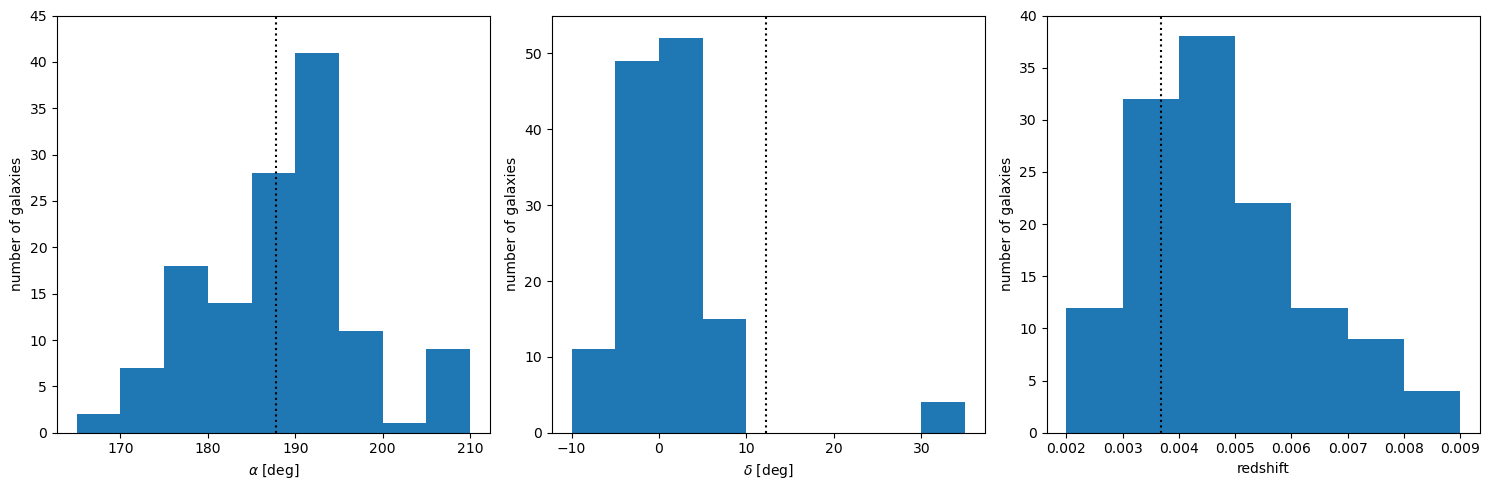

In [66]:
plt.figure(figsize=(15,5), tight_layout=True)

plt.subplot(131)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['RA'], 
         bins=np.arange(165, 215, 5))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').ra.deg, 0, 50, colors='k', linestyles='dotted')
plt.xlabel(r'$\alpha$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=45)

plt.subplot(132)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['DEC'], 
         bins=np.arange(-10, 40, 5))
plt.vlines(cluster_coords[table3_i].transform_to('icrs').dec.deg, 0, 100, colors='k', linestyles='dotted')
plt.xlabel(r'$\delta$ [deg]')
plt.ylabel('number of galaxies')
plt.ylim(ymax=55)

plt.subplot(133)
plt.hist(TF_SGA_cp4.loc[np.array(c_4r_in_cluster, dtype='object')[i][0]]['Z_DESI'], 
         bins=np.arange(0.002, 0.01, 0.001))
plt.vlines(cluster_v/c, 0, 100, colors='k', linestyles='dotted')
plt.xlabel('redshift')
plt.ylabel('number of galaxies')
plt.ylim(ymax=40);

In [76]:
help(ax_sky.get_transform())

Help on IdentityTransform in module matplotlib.transforms object:

class IdentityTransform(Affine2DBase)
 |  IdentityTransform(*args, **kwargs)
 |  
 |  A special class that does one thing, the identity transform, in a
 |  fast way.
 |  
 |  Method resolution order:
 |      IdentityTransform
 |      Affine2DBase
 |      AffineBase
 |      Transform
 |      TransformNode
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __str__ lambda self
 |  
 |  frozen(self)
 |      Return a frozen copy of this transform node.  The frozen copy will not
 |      be updated when its children change.  Useful for storing a previously
 |      known state of a transform where ``copy.deepcopy()`` might normally be
 |      used.
 |  
 |  get_affine(self)
 |      Get the affine part of this transform.
 |  
 |  get_matrix(self)
 |      Get the matrix for the affine part of this transform.
 |  
 |  inverted(self)
 |      Return the corresponding inverse transformation.
 |      
 |      It holds ``x

In [90]:
table3['R2t'][table3_i]/(cluster_v/H0)

0.13043478260869565

In [91]:
np.arctan(table3['R2t'][table3_i]/(cluster_v/H0))

0.1297025371559121